### Loading datasets

In [1]:
import torch
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

from data.dataset import MultiDataset

# Dataset and Loader
dataset_test = MultiDataset(
    ['data/same_vis_same_phys/train/sample_0/',
     'data/same_vis_same_phys/train/sample_1/',
     'data/same_vis_same_phys/train/sample_2/',
     'data/same_vis_same_phys/train/sample_3/'],
    img_size=(256, 256),
    buffer_size=4,
    random_order=True
    )

loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

In [2]:
plt.rcParams["savefig.bbox"] = 'tight'

def img_de_transform(img):
    # 0-1 to 1-255
    img = np.float32(np.array(img)) * 255.
    img = img.transpose((1, 2, 0))
    img = torch.from_numpy(img.copy())
    return img

def show(imgs):
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/tmp/ipykernel_10499/2886401148.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


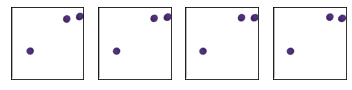

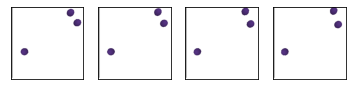

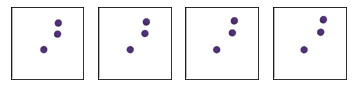

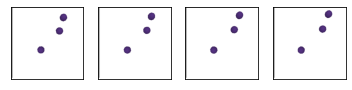

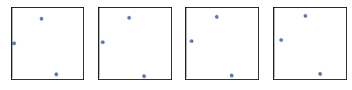

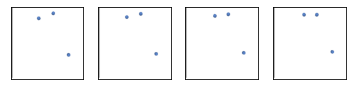

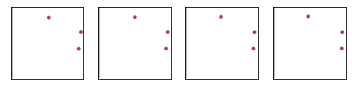

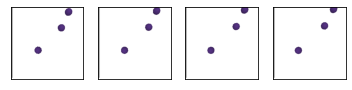

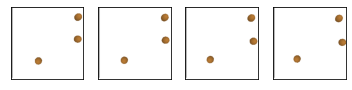

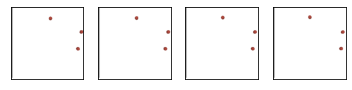

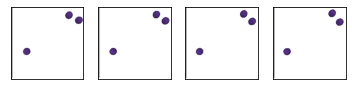

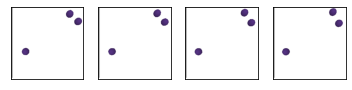

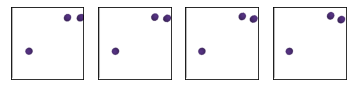

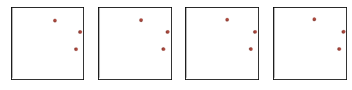

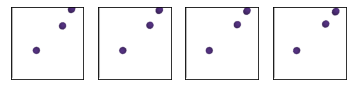

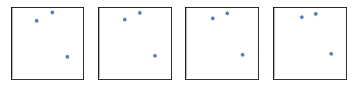

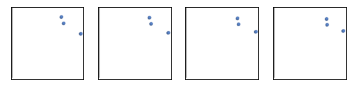

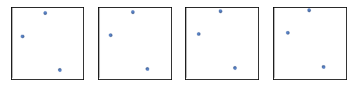

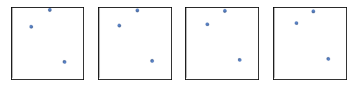

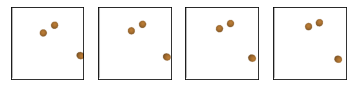

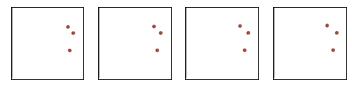

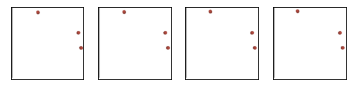

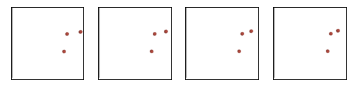

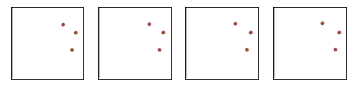

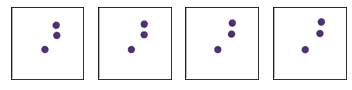

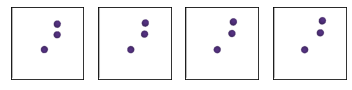

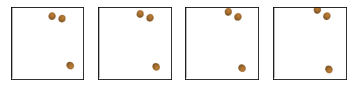

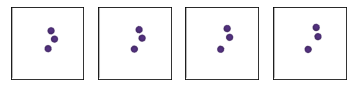

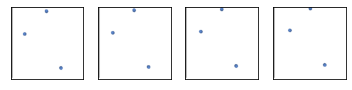

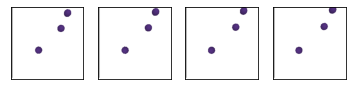

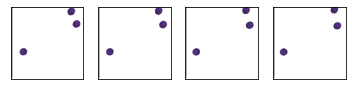

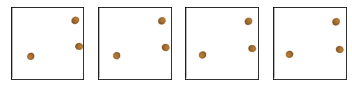

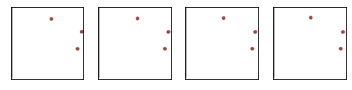

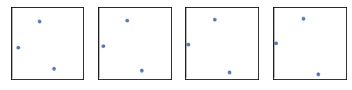

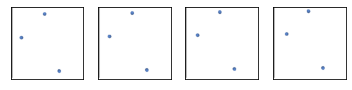

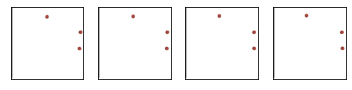

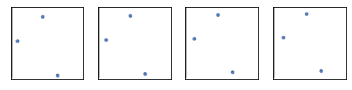

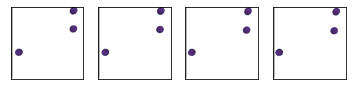

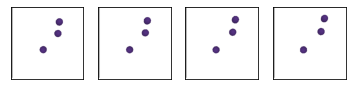

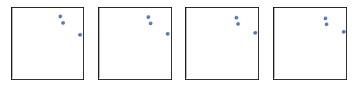

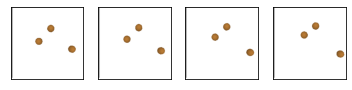

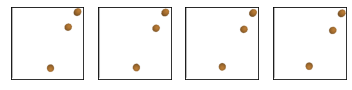

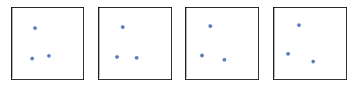

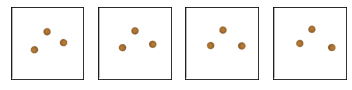

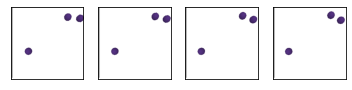

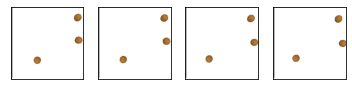

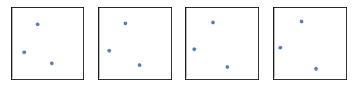

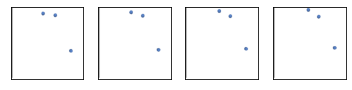

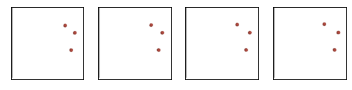

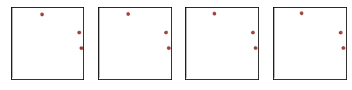

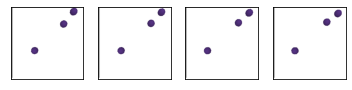

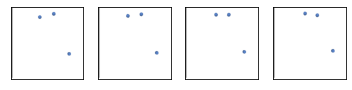

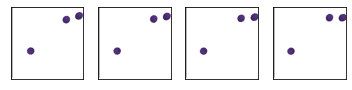

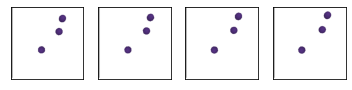

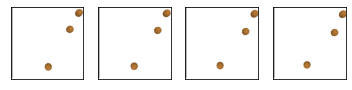

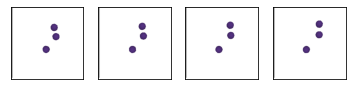

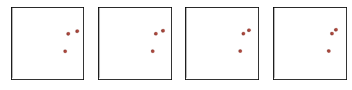

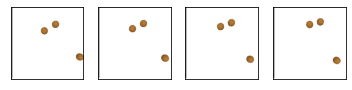

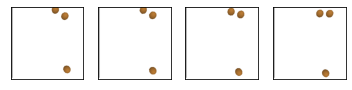

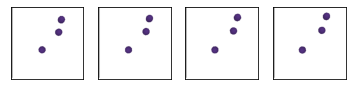

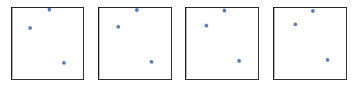

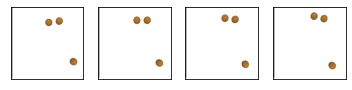

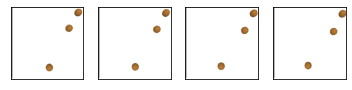

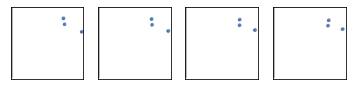

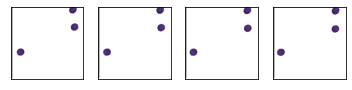

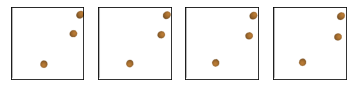

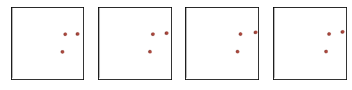

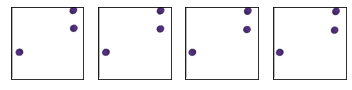

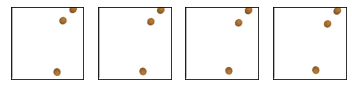

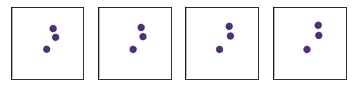

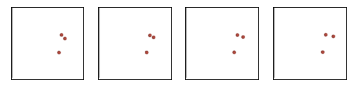

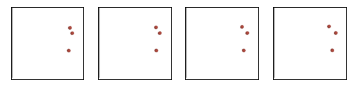

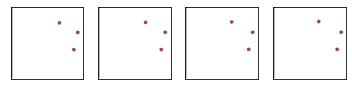

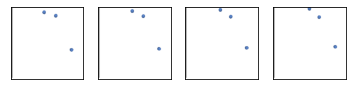

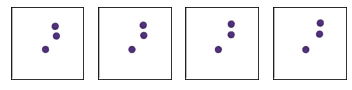

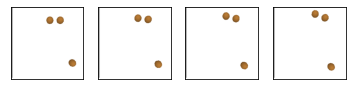

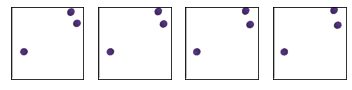

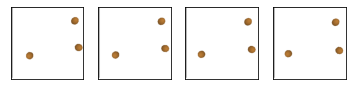

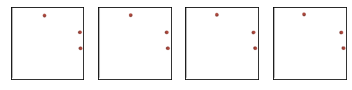

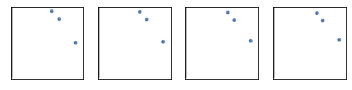

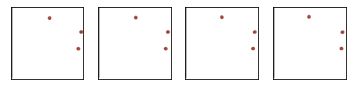

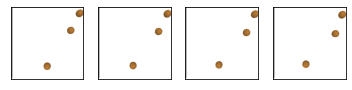

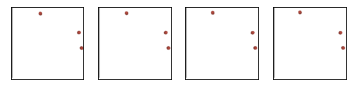

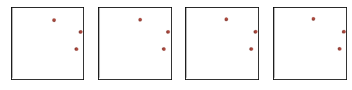

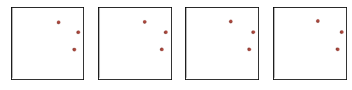

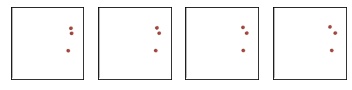

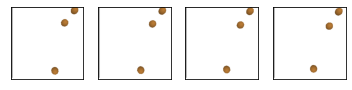

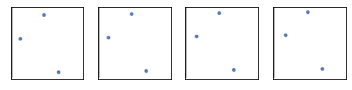

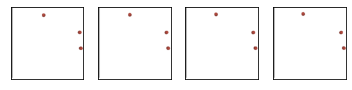

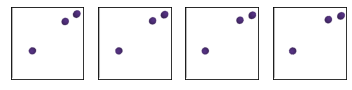

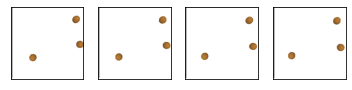

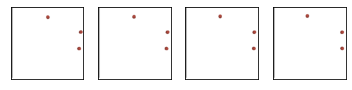

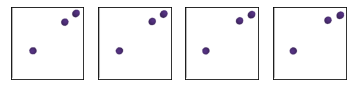

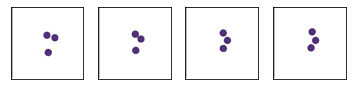

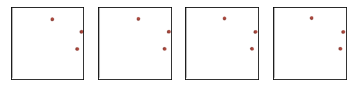

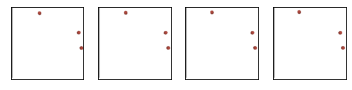

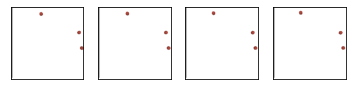

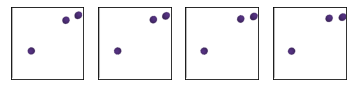

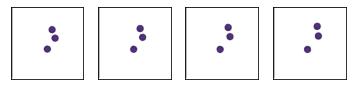

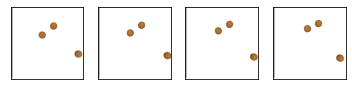

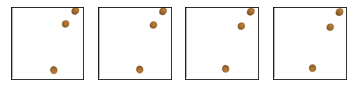

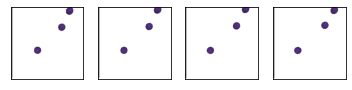

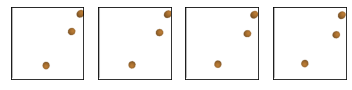

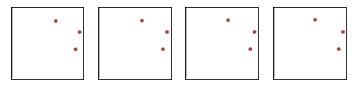

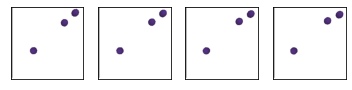

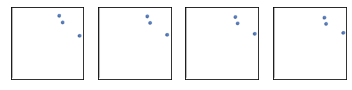

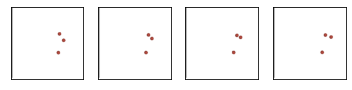

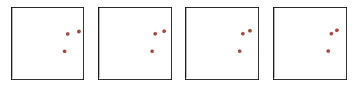

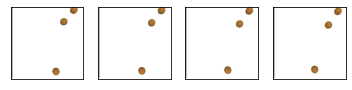

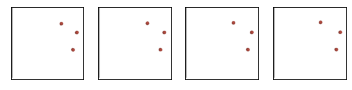

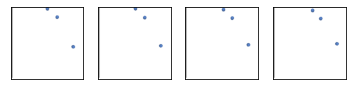

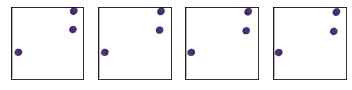

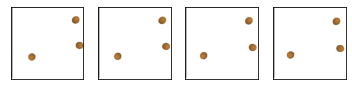

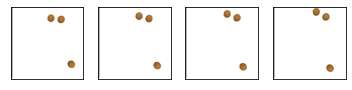

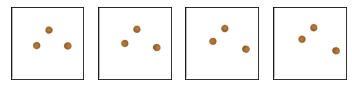

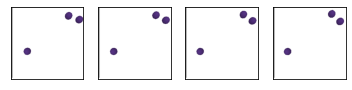

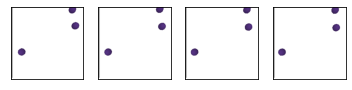

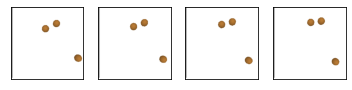

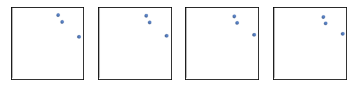

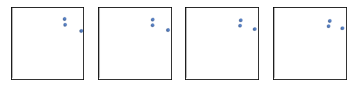

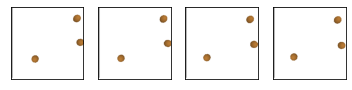

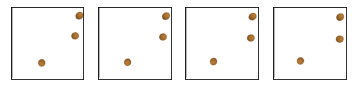

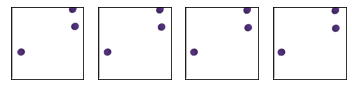

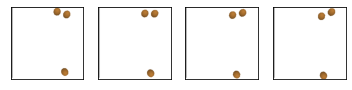

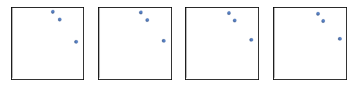

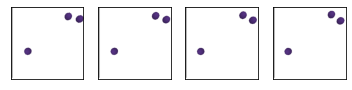

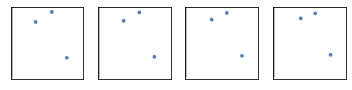

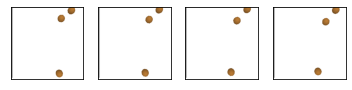

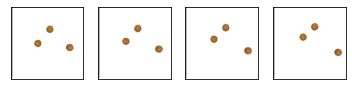

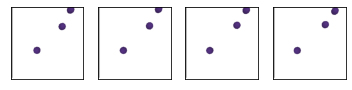

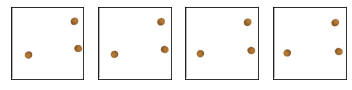

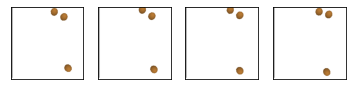

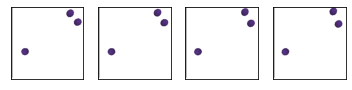

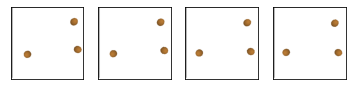

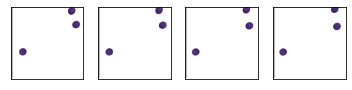

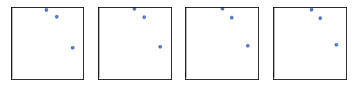

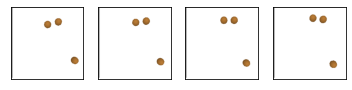

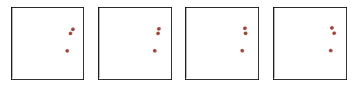

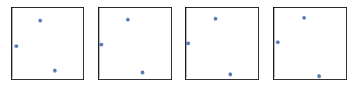

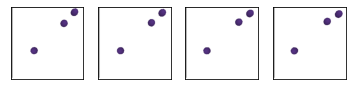

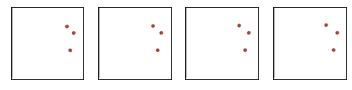

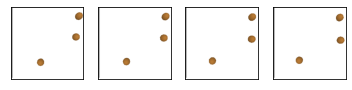

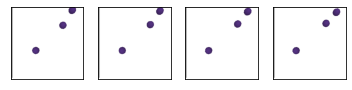

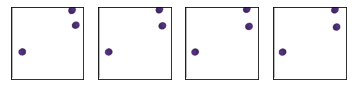

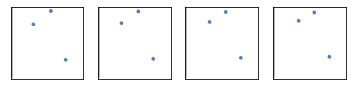

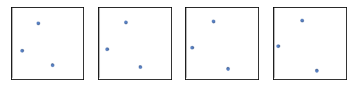

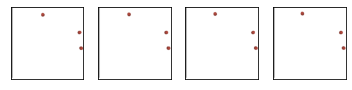

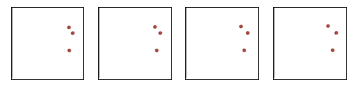

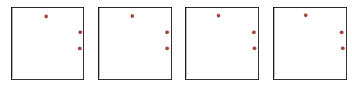

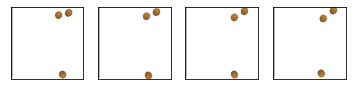

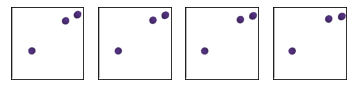

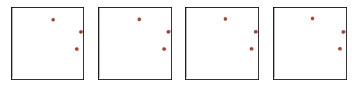

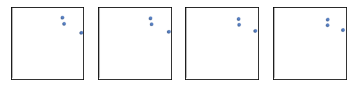

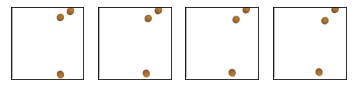

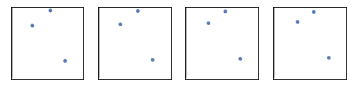

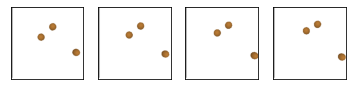

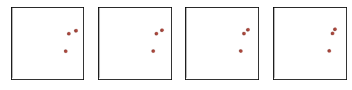

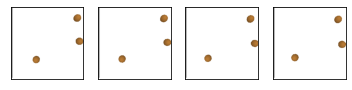

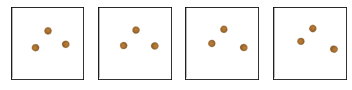

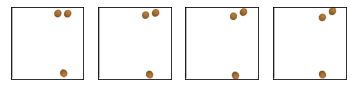

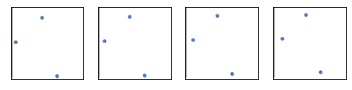

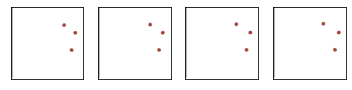

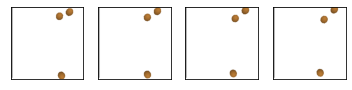

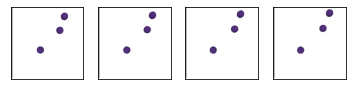

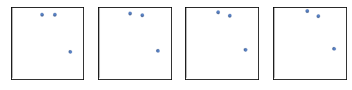

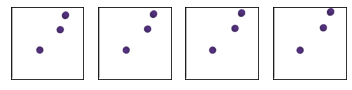

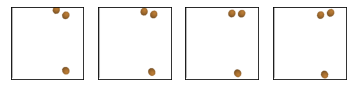

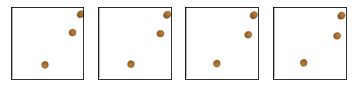

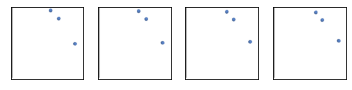

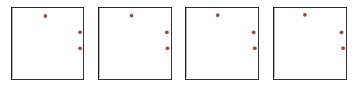

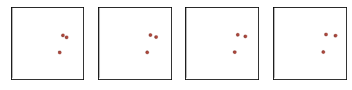

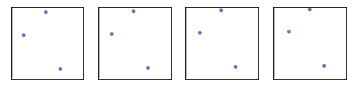

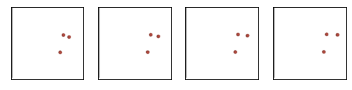

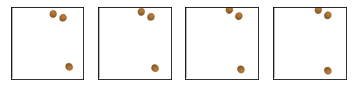

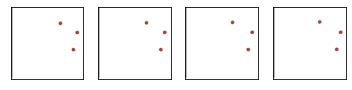

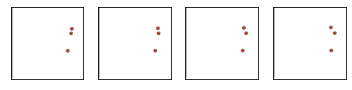

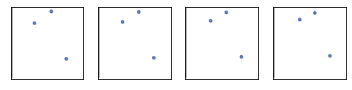

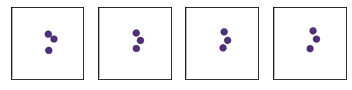

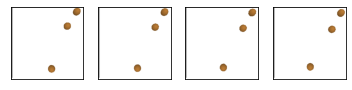

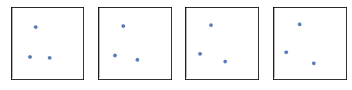

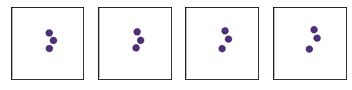

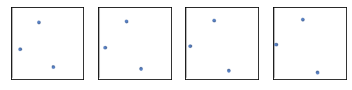

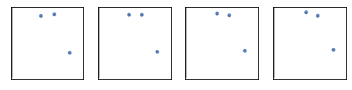

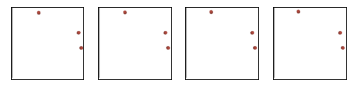

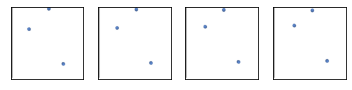

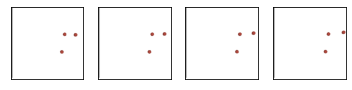

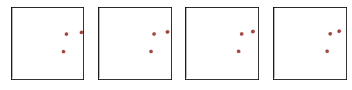

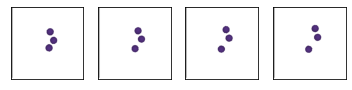

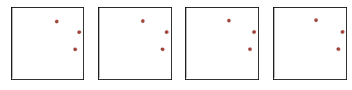

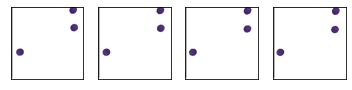

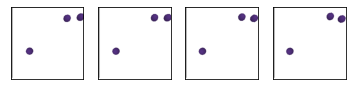

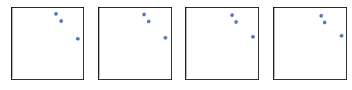

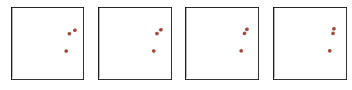

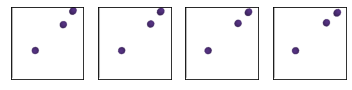

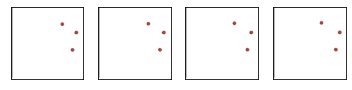

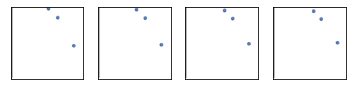

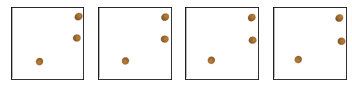

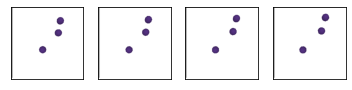

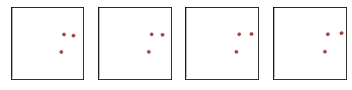

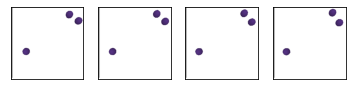

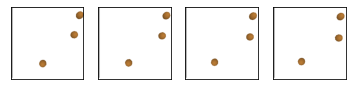

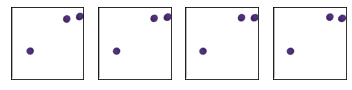

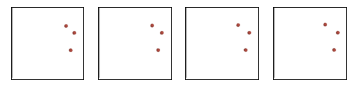

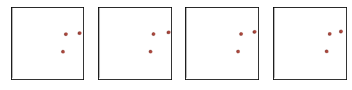

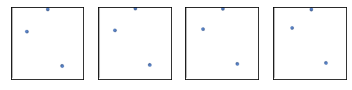

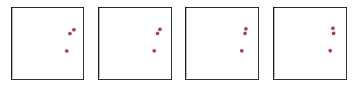

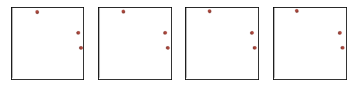

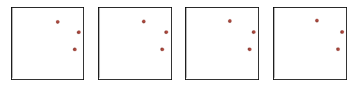

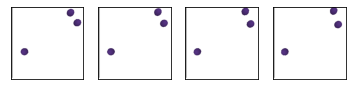

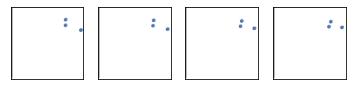

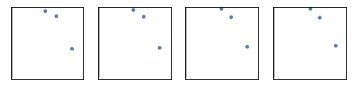

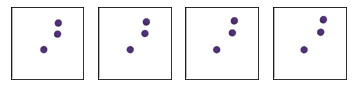

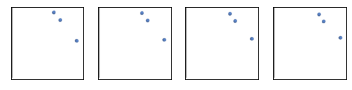

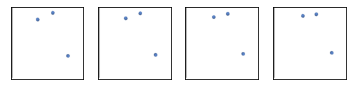

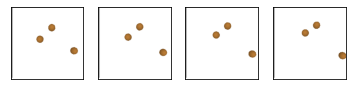

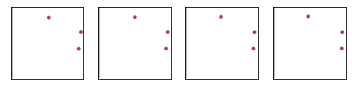

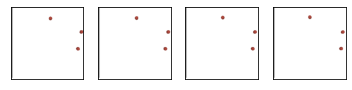

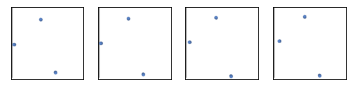

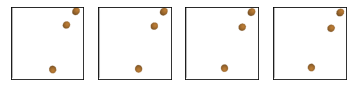

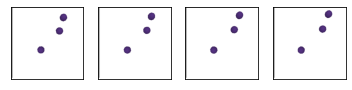

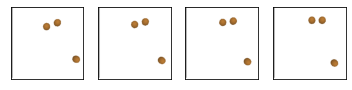

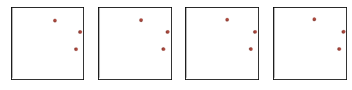

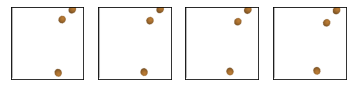

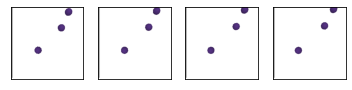

In [3]:
for output in iterator_train:
    for i in range(4):
        show(output['img_data'][i])